<a href="https://colab.research.google.com/github/abksyed/CNN-Image-Classification-and-Flask-Deployment/blob/master/12_TinyImageNet_Classification/JerryBhau/Annotations/Assignment_S12_Annotate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import requests
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [5]:
with open('Jerry.json') as fp: #Loading the JSON
    data = json.load(fp)

In [6]:
print(json.dumps(data["Image_4.jpg106340"], indent=2))

{
  "filename": "Image_4.jpg",
  "size": 106340,
  "regions": [
    {
      "shape_attributes": {
        "name": "rect",
        "x": 144,
        "y": 307,
        "width": 594,
        "height": 544
      },
      "region_attributes": {
        "Name": "Jerrry"
      }
    },
    {
      "shape_attributes": {
        "name": "rect",
        "x": 819,
        "y": 58,
        "width": 578,
        "height": 800
      },
      "region_attributes": {
        "Name": "Jerrry"
      }
    }
  ],
  "file_attributes": {
    "caption": "",
    "public_domain": "no",
    "image_url": ""
  }
}


### Exaplanation of the json file

The JSON file is a Key:Value pair in a text format, where the Keys are unique and mapped to respective data regarding it under values.

The main key is the Image Name and the value is characteristics such as,
- filename: the name of the file
- size: the size of the image.
- regions: this is an array consisting of the bounding boxes
    - shape_attributes: how the **Bounding Box** is defined, could be a circle, rectangle, etc.
        The **x** and **y** values are the top left corner of the Bounding Box.
        The **width** and **height** is the total width and height of the box.
    - region_attributes: this contained the label for the region, here **'Jerrry'**.
- file_attributes: The other extra data like captions, public_domain and urls.

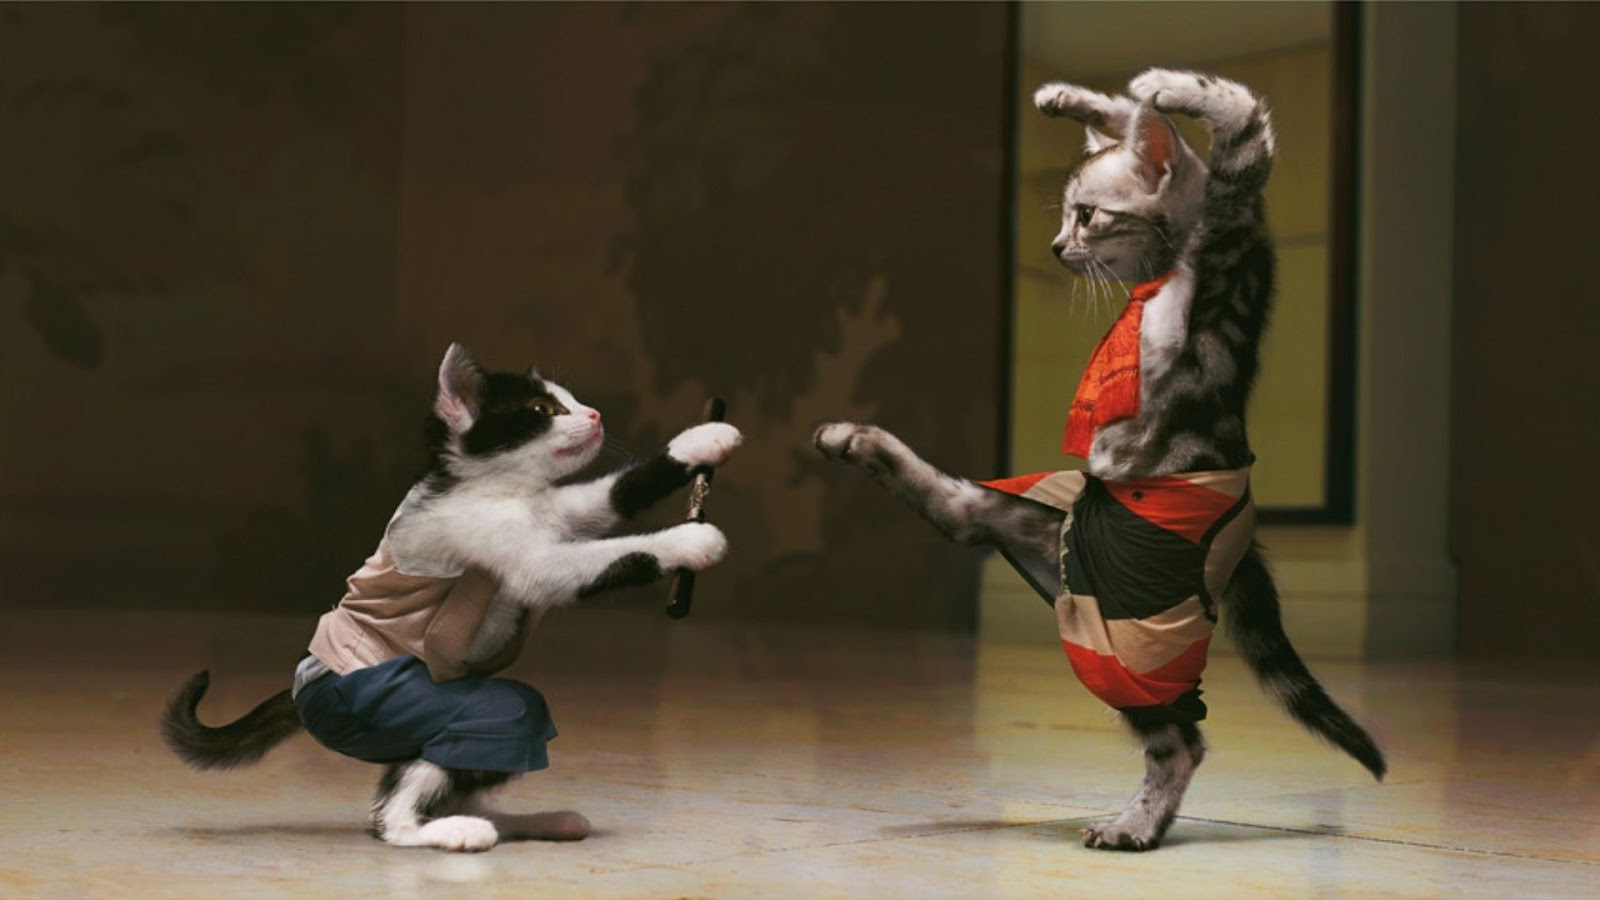

In [8]:
Image.open(data["Image_4.jpg106340"]["filename"]) #Displaying one of the Image!

In [9]:
def draw_BBox(img_annot):
    bboxes = []
    for bbox in img_annot["regions"]:
        shape_attrs = bbox["shape_attributes"]
        x = shape_attrs["x"]
        y = shape_attrs["y"]
        width = shape_attrs["width"]
        height = shape_attrs["height"]

        bboxes.append((x, y, width, height))

    return bboxes

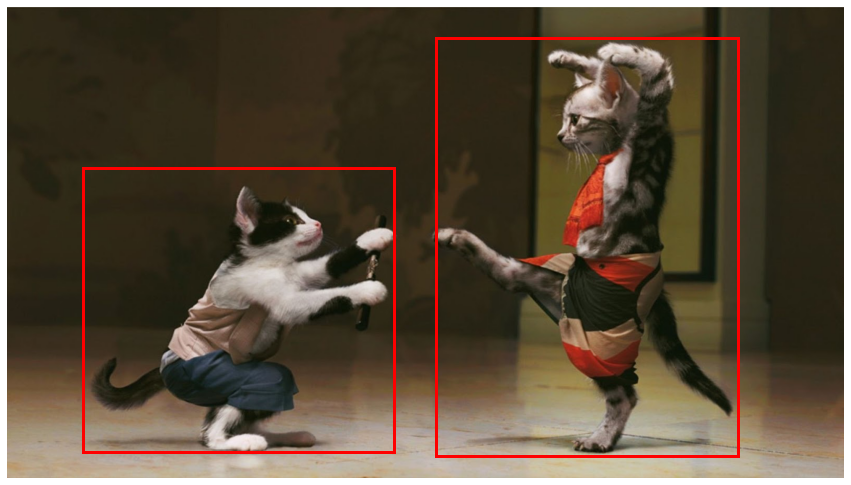

In [12]:
im = np.array(Image.open(data["Image_4.jpg106340"]["filename"]))
bboxes = draw_BBox(data["Image_4.jpg106340"])

# Create figure and axes
fig,ax = plt.subplots(1, figsize=(15,15))

# Display the image
ax.imshow(im)

for bbox in bboxes:
    x, y, width, height = bbox
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),width,height,linewidth=3,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
plt.axis('off')
plt.show() #Displaying Image after Annotation

In [14]:
def BBoxratio(ann):
    ratio = []
    img_width, img_height = Image.open(ann["filename"]).size
    for bbox in draw_BBox(ann):
        x, y, width, height = bbox
        ratio.append([width/img_width, height/img_height])
    return ratio

In [16]:
bb = []
for ann in data.values():
    bb.extend(BBoxratio(ann))

In [17]:
bb = np.array(bb)

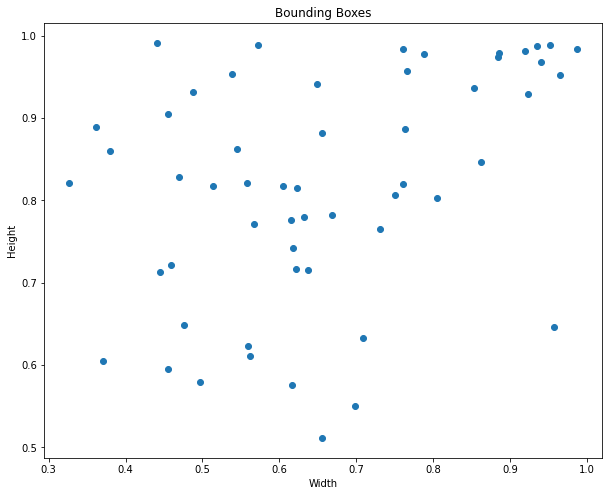

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(bb[:,0], bb[:,1])
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Bounding Boxes')
plt.show()

In [26]:
from sklearn.cluster import KMeans

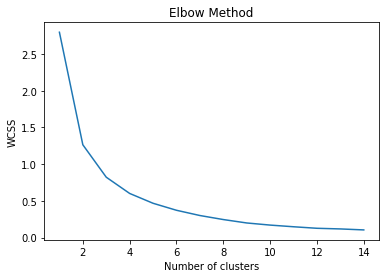

In [27]:
wcss = []
for c in range(1, 15):
    kmeans = KMeans(n_clusters=c, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(bb)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**The Data looks to elbow at 3 or 4. So checking both the K=3 and K=4**

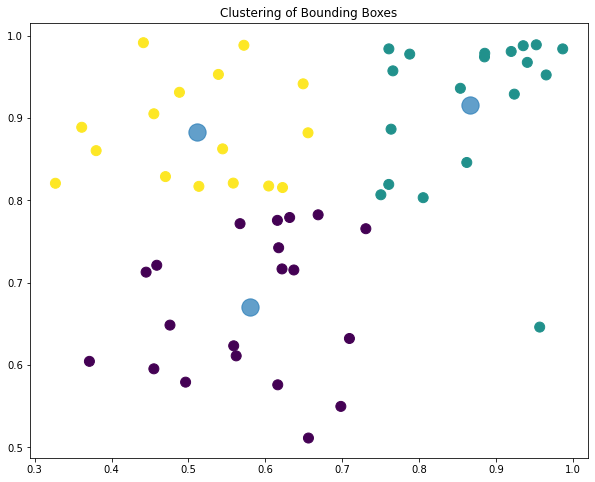

In [37]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0) #K=3
pred_y = kmeans.fit_predict(bb)
plt.figure(figsize=(10,8))
plt.scatter(bb[:,0], bb[:,1], c=pred_y, s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7)
plt.title('Clustering of Bounding Boxes')
plt.show()

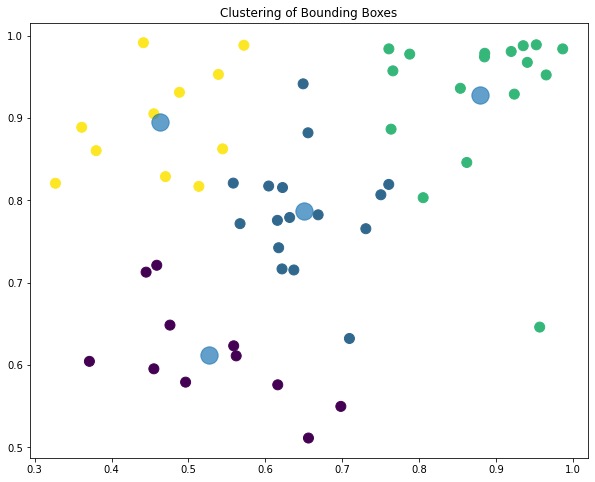

In [39]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0) #K=4
pred_y = kmeans.fit_predict(bb)
plt.figure(figsize=(10,8))
plt.scatter(bb[:,0], bb[:,1], c=pred_y, s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7)
plt.title('Clustering of Bounding Boxes')
plt.show()

In [43]:
def iou(box, cent):
    I = np.minimum(cent[:, 0], box[0]) * np.minimum(cent[:, 1], box[1])
    box_area = box[0] * box[1]
    centroid_area = cent[:, 0]* cent[:, 1]
    U = box_area + centroid_area - I
    iou = I / U
    return (np.max(iou), np.argmax(iou))

In [45]:
def plotIOU(X, Y):
  plt.scatter(X, Y)
  plt.plot(X, Y)
  plt.xlabel("#Centroids")
  plt.ylabel("Mean Average Precision")
  plt.xticks(np.arange(1, 11))
  plt.show()

In [46]:
cent = {}
cluster = {}
miou = []
K = range(1, 11)

for k in K:
  kmeansModel = KMeans(n_clusters=k).fit(bb)
  cent[k] = kmeansModel.cluster_centers_
  maxiou = np.array([iou(box, cent[k])  for box in bb])
  cluster[k] = maxiou[:, 1].astype(np.uint8)
  miou.append(np.mean(maxiou[:, 0]))

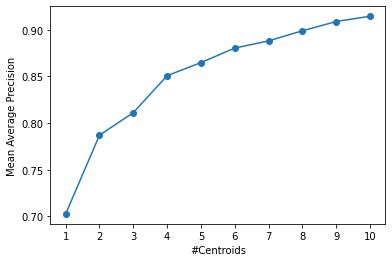

In [47]:
plotIOU(K, miou)